In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SGLBO

## PQC

C:\Users\denni\PycharmProjects\squlearn\venv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


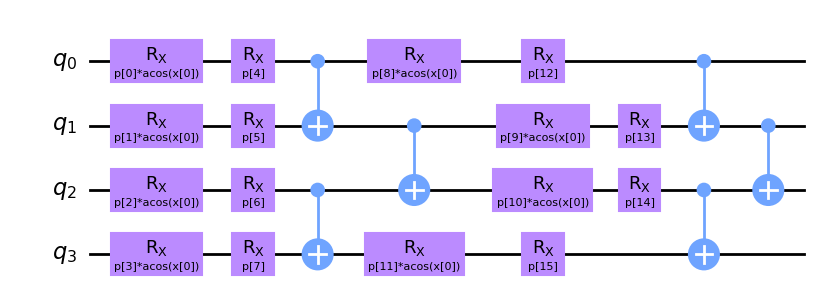

In [2]:
executor = Executor("statevector_simulator")

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

## Observable

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [4]:
def sigmoid(x, a, b, c):
    return 1 / (1 + np.exp(-a * (x - b) / c))

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.random.rand(op.num_parameters)

qnn_simulator_adam = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    Adam({"lr": 0.01,"log_file": "adam_sigmoid.log", "maxiter": 300}),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, 
    parameter_seed=124
)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)

qnn_simulator_adam.fit(x_train, y_train)

fit: 100%|██████████| 300/300 [15:13<00:00,  2.99s/it]

In [6]:
#x0 = [[i * 0.02] for i in range(15)]
x0 = [[1e-4], [2e-4], [3e-4], [4e-4], [5e-4], [6e-4], [7e-4], [8e-4], [9e-4], [1e-3], [2e-3], [3e-3], [4e-3], [5e-3], [6e-3], [7e-3], [8e-3], [9e-3], [1e-2], [2e-2], [3e-2], [4e-2], [5e-2], [6e-2], [7e-2], [8e-2], [9e-2], [1e-1], [2e-1]]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.2)], "log_file": "sglbo_sigmoid.log",
                     "bo_n_calls": 60, "bo_x0_points": x0, "maxiter": 300}

qnn_simulator_sglbo = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, 
    parameter_seed=124
)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)

qnn_simulator_sglbo.fit(x_train, y_train)


fit:   0%|          | 0/300 [00:00<?, ?it/s]BOP  fval:  3.7205733675721917  x:  [0.0001]
BOP  fval:  3.7101619672431396  x:  [0.0002]
BOP  fval:  3.69977196534892  x:  [0.0003]
BOP  fval:  3.689403416674601  x:  [0.0004]
BOP  fval:  3.6790563755640093  x:  [0.0005]
BOP  fval:  3.6687308959191136  x:  [0.0006]
BOP  fval:  3.658427031199444  x:  [0.0007]
BOP  fval:  3.6481448344214904  x:  [0.0008]
BOP  fval:  3.637884358158137  x:  [0.0009]
BOP  fval:  3.6276456545381035  x:  [0.001]
BOP  fval:  3.526467263391702  x:  [0.002]
BOP  fval:  3.42752016053521  x:  [0.003]
BOP  fval:  3.330849070718362  x:  [0.004]
BOP  fval:  3.236494184671199  x:  [0.005]
BOP  fval:  3.1444911346753246  x:  [0.006]
BOP  fval:  3.054870981499413  x:  [0.007]
BOP  fval:  2.9676602125592844  x:  [0.008]
BOP  fval:  2.882880751136598  x:  [0.009]
BOP  fval:  2.800549976464651  x:  [0.01]
BOP  fval:  2.1125862816633965  x:  [0.02]
BOP  fval:  1.6572885279837644  x:  [0.03]
BOP  fval:  1.3903538281913042  x:  [0

## predict vs. actual function

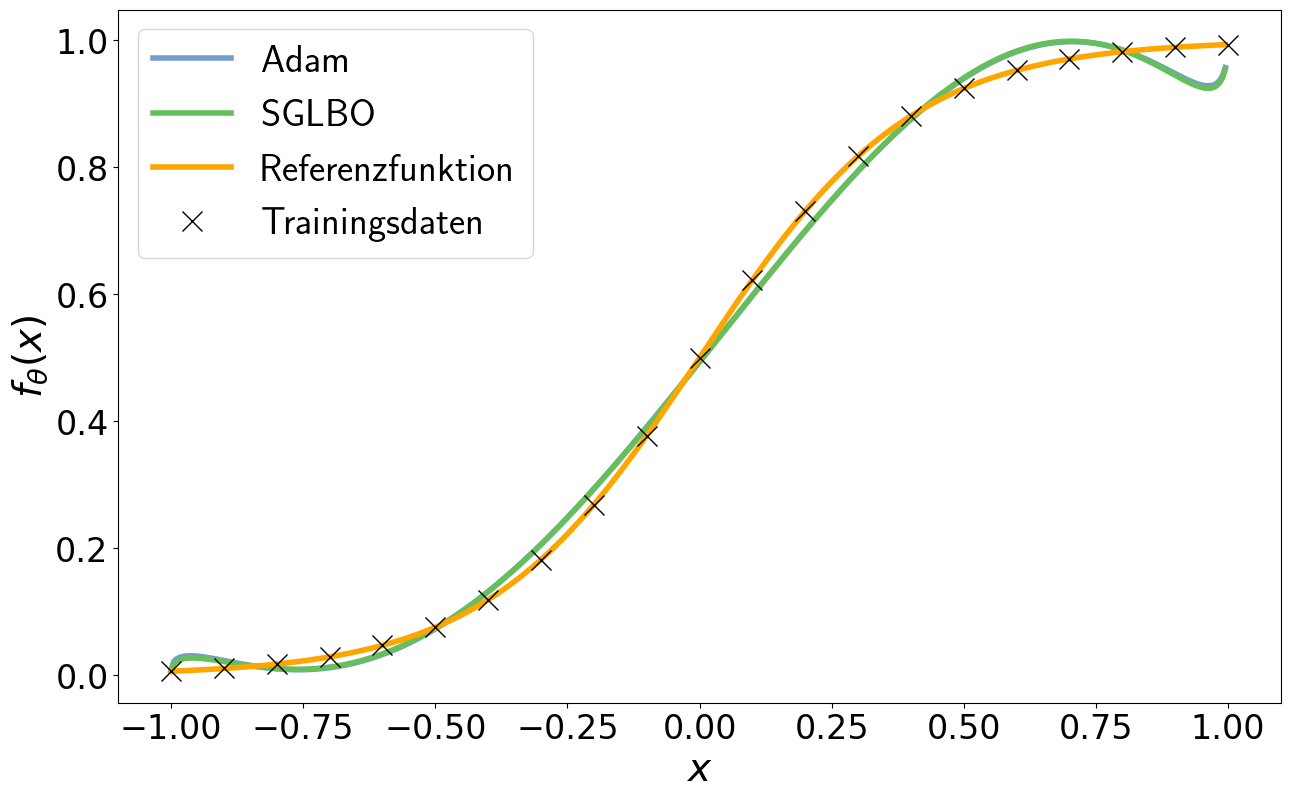

In [12]:
x = np.arange(np.min(x_train), np.max(x_train), 0.005)
y_adam = qnn_simulator_adam.predict(x)
y_sglbo = qnn_simulator_sglbo.predict(x)

plt.rc('text', usetex=False)
plt.figure(figsize=(15, 9))
plt.plot(x, y_adam, label="Adam", linewidth=4, color="#729ECE")
plt.plot(x, y_sglbo, label="SGLBO", linewidth=4, color="#67BF5C")
plt.plot(x, sigmoid(x,5,0,1), label="Referenzfunktion", linewidth=4, color="orange")
plt.plot(x_train, sigmoid(x_train,5,0,1), marker="x", color="black", label="Trainingsdaten", linestyle=" ", markersize=14)

plt.rc('text', usetex=True)

#.title(r'$f(x) = \frac{1}{1 + \exp(-5x)}$', fontsize=34)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r'$x$', fontsize=28)
plt.ylabel(r'$f_{\theta}(x)$', fontsize=28)
plt.legend(fontsize=28)

Text(0, 0.5, '$f_{\\theta}(x)$')

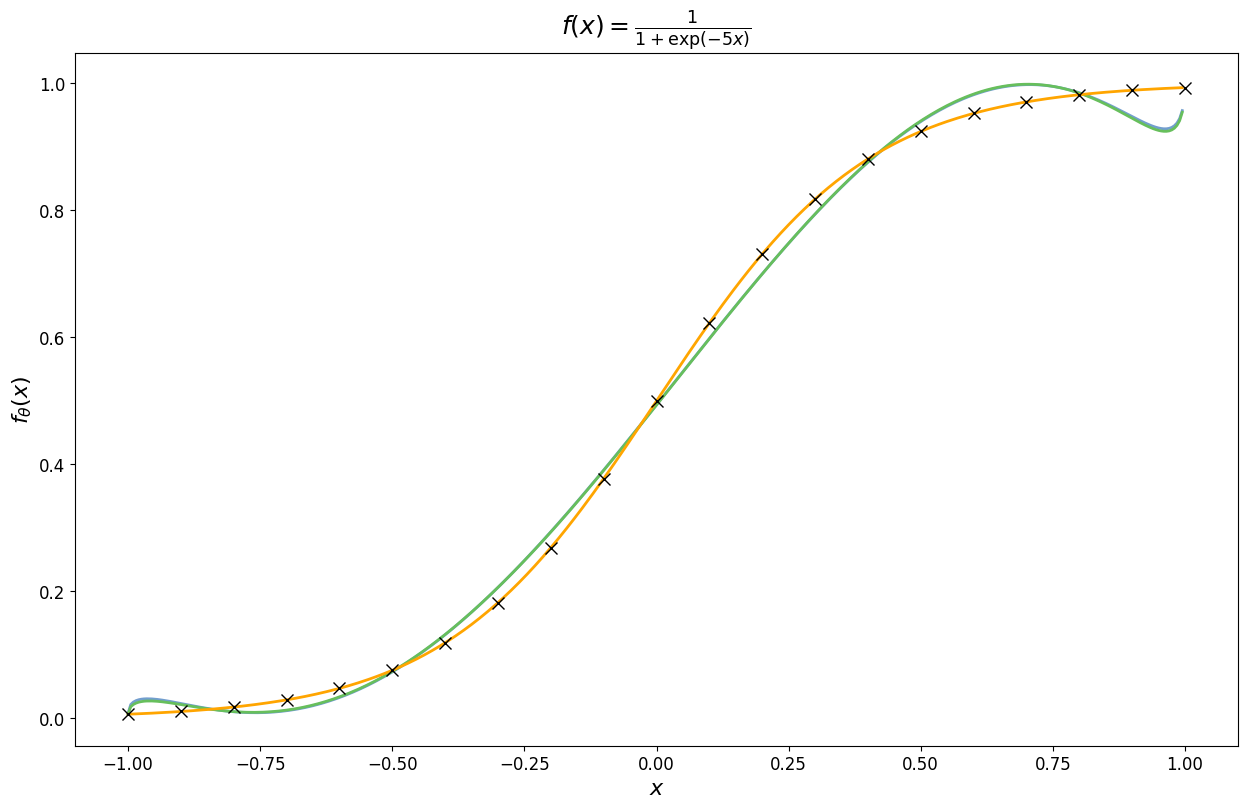

In [8]:

plt.rc('text', usetex=False)

plt.figure(figsize=(15, 9))
plt.plot(x, y_adam, label="Adam", linewidth=2, color="#729ECE")
plt.plot(x, y_sglbo, label="SGLBO", linewidth=2, color="#67BF5C")
plt.plot(x, sigmoid(x,5,0,1), label="Referenzfunktion", linewidth=2, color="orange")
plt.plot(x_train, sigmoid(x_train,5,0,1), marker="x", color="black", label="Trainingsdaten", linestyle=" ", markersize=8)

plt.rc('text', usetex=True)

plt.title(r'$f(x) = \frac{1}{1 + \exp(-5x)}$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$f_{\theta}(x)$', fontsize=16)
#plt.legend(fontsize=16)